In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!unzip '/content/drive/My Drive/Dataset/hand-gesture.zip' -d '/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/07/06_index/frame_07_06_0027.png  
  inflating: /dataset/07/06_index/frame_07_06_0028.png  
  inflating: /dataset/07/06_index/frame_07_06_0029.png  
  inflating: /dataset/07/06_index/frame_07_06_0030.png  
  inflating: /dataset/07/06_index/frame_07_06_0031.png  
  inflating: /dataset/07/06_index/frame_07_06_0032.png  
  inflating: /dataset/07/06_index/frame_07_06_0033.png  
  inflating: /dataset/07/06_index/frame_07_06_0034.png  
  inflating: /dataset/07/06_index/frame_07_06_0035.png  
  inflating: /dataset/07/06_index/frame_07_06_0036.png  
  inflating: /dataset/07/06_index/frame_07_06_0037.png  
  inflating: /dataset/07/06_index/frame_07_06_0038.png  
  inflating: /dataset/07/06_index/frame_07_06_0039.png  
  inflating: /dataset/07/06_index/frame_07_06_0040.png  
  inflating: /dataset/07/06_index/frame_07_06_0041.png  
  inflating: /dataset/07/06_index/frame_07_06_0042.png  
  inflating: /dataset/07/06_index/fra

In [ ]:
import sys
import os
import numpy as np
from PIL import Image
import string
import matplotlib.pyplot as plt

from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model

DATA_DIR = '/dataset'

In [ ]:
def preprocessing(target_size):
  datagen = ImageDataGenerator(
      rescale=1./255,
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest',
      validation_split=0.2
  )

  train_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=target_size,
      class_mode='categorical',
      subset='training'
  )

  validation_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=target_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, validation_generator

In [ ]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs is None:
      logs = {}
    if logs.get('val_accuracy') >= 0.98:
      print(f'Epoch {epoch}: Reached accuracy threshold')
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50, EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

def create_model(model_name, num_classes):
  if model_name == "VGG19":
    base_model = VGG19(weights='imagenet', include_top=False)
  elif model_name == "InceptionV3":
    base_model = InceptionV3(weights='imagenet', include_top=False)
  elif model_name == "ResNet50":
    base_model = ResNet50(weights='imagenet', include_top=False)
  elif model_name == "EfficientNetB7":
    base_model = EfficientNetB7(weights='imagenet', include_top=False)

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze layers up to the 7th layer
  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model


def my_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# model_names = ["InceptionV3", "VGG19", "ResNet50", "EfficientNetB7"]
model_names = ["MyModel", "InceptionV3", "VGG19"]

def train(epochs, batch_size, verbose, num_classes):
  callback = mycallback()

  # Create list of model

  history_list = []
  for model_name in model_names:
    if model_name == "MyModel":
      train_generator, validation_generator = preprocessing((224, 224))
    elif model_name == "EfficientNetB7":
      train_generator, validation_generator = preprocessing((600, 600))
    elif model_name == "VGG19":
      train_generator, validation_generator = preprocessing((224, 224))
    elif model_name == "InceptionV3":
      train_generator, validation_generator = preprocessing((299, 299))
    elif model_name == "ResNet50":
      train_generator, validation_generator = preprocessing((224, 224))

    print(f'\n Training on {model_name}... \n')

    if model_name == "MyModel":
      model = my_model()
    else:
      model = create_model(model_name, num_classes)

    history = model.fit(train_generator,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = verbose,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), callback],
                        validation_data = validation_generator)
    history_list.append(history)

  return history_list

In [ ]:
epochs = 20
batch_size = 32
verbose = 1

num_classes = 10

history_list = train(epochs, batch_size, verbose, num_classes)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.

 Training on MyModel... 

Epoch 1/20
  6/500 [..............................] - ETA: 44s - loss: 2.3684 - accuracy: 0.1198

500/500 [==============================] - 81s 146ms/step - loss: 0.2695 - accuracy: 0.9062 - val_loss: 1.0261 - val_accuracy: 0.7368
Epoch 2/20
500/500 [==============================] - 80s 160ms/step - loss: 0.0266 - accuracy: 0.9865 - val_loss: 1.6701 - val_accuracy: 0.6737
Epoch 3/20
500/500 [==============================] - 73s 146ms/step - loss: 0.0344 - accuracy: 0.9856 - val_loss: 2.2674 - val_accuracy: 0.7950
Epoch 4/20
500/500 [==============================] - 70s 140ms/step - loss: 0.0263 - accuracy: 0.9876 - val_loss: 1.6314 - val_accuracy: 0.7897
Epoch 5/20
500/500 [==============================] - 72s 144ms/step - loss: 0.0228 - accuracy: 0.9882 - val_loss: 1.5344 - val_accuracy: 0.7868
Epoch 6/20
500/500 [==============================] - 72s 143ms/step - loss: 0.0163 - accuracy: 0.9901 - val_loss: 1.3238 - val_accuracy: 0.7835
Epoch 7/20
500/500 [==============================] - 70s 140ms/step - loss: 0.0171 - accuracy: 0.9898 - val_loss: 0.8667 - val_accuracy: 0.8

In [ ]:
def visualization(val_accuracy_list, val_loss_list, model_names):
    epochs_list = [i+1 for i in range(epochs)]

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))

    for index in range(len(val_accuracy_list)):
        accuracy_array = np.empty(epochs)
        accuracy_array[:] = np.nan
        accuracy_array[:len(val_accuracy_list[index])] = val_accuracy_list[index]
        # Validation accuracy visualization
        axes[0].plot(epochs_list, accuracy_array, label=model_names[index])
        axes[0].set_title('Validation accuracy between models')
        axes[0].legend()

        loss_array = np.empty(epochs)
        loss_array[:] = np.nan
        loss_array[:len(val_loss_list[index])] = val_loss_list[index]
        # Validation loss visualization
        axes[1].plot(epochs_list, loss_array, label=model_names[index])
        axes[1].set_title('Validation loss between models')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

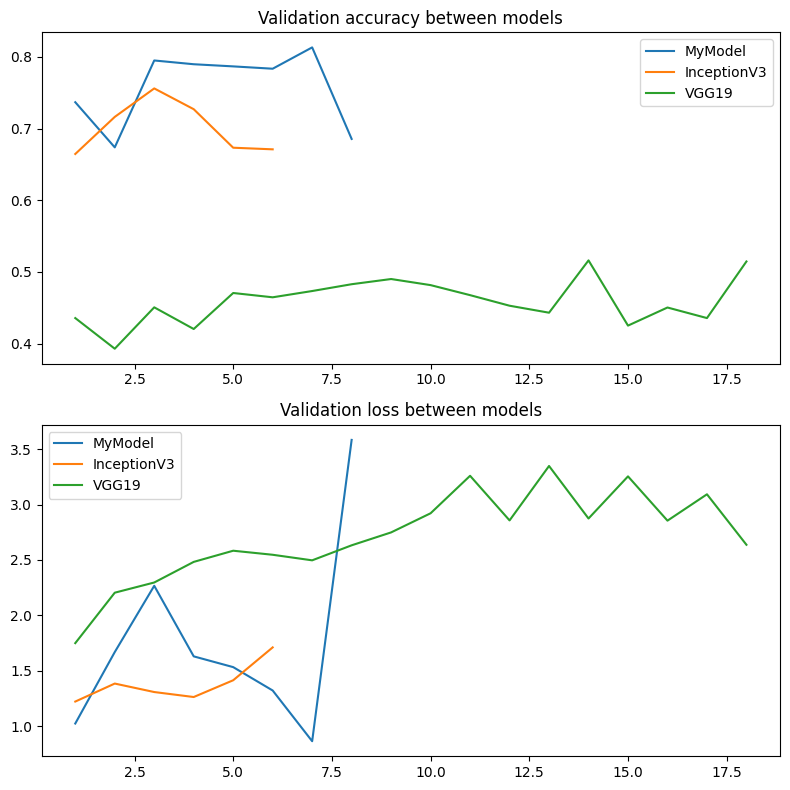

In [ ]:
val_accuracy_list = []
val_loss_list = []

for history in history_list:
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  val_accuracy_list.append(val_accuracy)
  val_loss_list.append(val_loss)

visualization(val_accuracy_list, val_loss_list, model_names)

In [ ]:
def preprocessing(target_size):
  datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2
  )

  train_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=target_size,
      class_mode='categorical',
      subset='training'
  )

  validation_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=target_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, validation_generator

In [ ]:
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50, EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

def create_model(model_name, num_classes):
  if model_name == "VGG19":
    base_model = VGG19(weights='imagenet', include_top=False)
  elif model_name == "InceptionV3":
    base_model = InceptionV3(weights='imagenet', include_top=False)
  elif model_name == "ResNet50":
    base_model = ResNet50(weights='imagenet', include_top=False)
  elif model_name == "EfficientNetB7":
    base_model = EfficientNetB7(weights='imagenet', include_top=False)

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze layers up to the 7th layer
  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model


def my_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# model_names = ["InceptionV3", "VGG19", "ResNet50", "EfficientNetB7"]
model_names = ["MyModel", "InceptionV3", "VGG19"]

def train(epochs, batch_size, verbose, num_classes):
  callback = mycallback()

  # Create list of model

  history_list = []
  model_list = []

  for model_name in model_names:
    if model_name == "MyModel":
      train_generator, validation_generator = preprocessing((224, 224))
    elif model_name == "EfficientNetB7":
      train_generator, validation_generator = preprocessing((600, 600))
    elif model_name == "VGG19":
      train_generator, validation_generator = preprocessing((224, 224))
    elif model_name == "InceptionV3":
      train_generator, validation_generator = preprocessing((299, 299))
    elif model_name == "ResNet50":
      train_generator, validation_generator = preprocessing((224, 224))

    print(f'\n Training on {model_name}... \n')

    if model_name == "MyModel":
      model = my_model()
    else:
      model = create_model(model_name, num_classes)

    history = model.fit(train_generator,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = verbose,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1), callback],
                        validation_data = validation_generator)
    history_list.append(history)
    model_list.append(model)

  return model_list, history_list

In [ ]:
epochs = 20
batch_size = 32
verbose = 1

num_classes = 10

model_list, history_list = train(epochs, batch_size, verbose, num_classes)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.

 Training on MyModel... 

Epoch 1/20
500/500 [==============================] - 308s 598ms/step - loss: 2.1390 - accuracy: 0.1919 - val_loss: 2.1295 - val_accuracy: 0.2192
Epoch 2/20
500/500 [==============================] - 321s 643ms/step - loss: 1.8345 - accuracy: 0.3142 - val_loss: 1.7592 - val_accuracy: 0.3713
Epoch 3/20
500/500 [==============================] - 324s 647ms/step - loss: 1.4611 - accuracy: 0.4631 - val_loss: 1.5824 - val_accuracy: 0.4507
Epoch 4/20
500/500 [==============================] - 294s 589ms/step - loss: 1.1707 - accuracy: 0.5717 - val_loss: 1.2232 - val_accuracy: 0.5785
Epoch 5/20
500/500 [==============================] - 298s 596ms/step - loss: 0.8738 - accuracy: 0.6809 - val_loss: 1.1033 - val_accuracy: 0.6227
Epoch 6/20
500/500 [==============================] - 319s 638ms/step - loss: 0.6532 - accuracy: 0.7577 - val_loss: 0.8516 - val_accuracy: 0.7072
Epoch 7/20

In [ ]:
val_accuracy_list = []
val_loss_list = []

for history in history_list:
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  val_accuracy_list.append(val_accuracy)
  val_loss_list.append(val_loss)

visualization(val_accuracy_list, val_loss_list, model_names)